### REINFORCE 구현

In [1]:
# 라이브러리 

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [2]:
# Hyperparameters

learning_rate = 0.002
gamma = 0.98

In [6]:
# 메인 함수

def main():
    env = gym.make('CartPole-v1')
    pi = Policy()
    score = 0.0
    print_interval = 20
    
    for n_epi in range(1000):
        s = env.reset()
        done = False
        
        while not done:
            prob = pi(torch.from_numpy(s).float())
            m = Categorical(prob)
            a = m.sample()
            s_prime, r, done, info = env.step(a.item())
            pi.put_data((r, prob[a]))
            s = s_prime
            score += r
            
        pi.train_net()
        if n_epi%print_interval==0 and n_epi!=0:
            print('# of episode:{}, avg score :{}'.format(n_epi, score/print_interval))
            score = 0.0
    env.close()

In [7]:
# 정책 네트워크클래스

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.data = []
        
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 2)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        return x
    
    def put_data(self, item):
        self.data.append(item)
        
    def train_net(self):
        R=0
        self.optimizer.zero_grad()
        for r, prob in self.data[::-1]:
            R = r + gamma * R
            loss = -R * torch.log(prob)
            loss.backward()
        self.optimizer.step()
        self.data = []

In [8]:
main()

# of episode:20, avg score :18.8
# of episode:40, avg score :24.7
# of episode:60, avg score :47.0
# of episode:80, avg score :40.8
# of episode:100, avg score :65.35
# of episode:120, avg score :63.15
# of episode:140, avg score :106.4
# of episode:160, avg score :69.55
# of episode:180, avg score :56.35
# of episode:200, avg score :138.4
# of episode:220, avg score :200.25
# of episode:240, avg score :155.9
# of episode:260, avg score :149.85
# of episode:280, avg score :163.5
# of episode:300, avg score :196.95
# of episode:320, avg score :162.45
# of episode:340, avg score :129.7
# of episode:360, avg score :134.35
# of episode:380, avg score :120.15
# of episode:400, avg score :133.75
# of episode:420, avg score :260.05
# of episode:440, avg score :467.45
# of episode:460, avg score :281.8
# of episode:480, avg score :223.55
# of episode:500, avg score :248.75
# of episode:520, avg score :254.5
# of episode:540, avg score :222.55
# of episode:560, avg score :149.35
# of episode:58

### TD Actor-Critic 구현


In [10]:
# 라이브러리 import 및 하이퍼 파라미터 정의

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Hyperparameters
learning_rate = 0.0002
gamma = 0.98
n_rollout = 10

# 밸류 네트워크가 평가를 대신해 주기 때문에 액터-크리틱 방법론은 학습할때 리턴을 필요로 하지 않는다.
# 따라서 리턴을 관측할 때까지 기다릴 필요 없이 하나의 데이터가 생기면 바로 네트워크를 업데이트 할 수 있다.
# n_rollout이 몇 틱의 데이터를 쌓아서 업데이트 할지를 내타내는 변수이다.

In [23]:
# 메인 함수

def main():
    env = gym.make('CartPole-v1')
    model = ActorCritic()
    print_interval = 20
    score = 2.0
    
    for n_epi in range(1000):
        done = False
        s = env.reset()
        while not done:
            for t in range(n_rollout):
                prob = model.pi(torch.from_numpy(s).float())
                m = Categorical(prob)
                a = m.sample().item()
                s_prime, r, done, info = env.step(a)
                model.put_data((s,a,r,s_prime,done))
                
                s = s_prime
                score += r
                
                if done:
                    break
                    
            model.train_net()
            
        if n_epi%print_interval==0 and n_epi!=0:
            print('# of episode :{}, avg score : {:.1f}'.format(n_epi, score/print_interval))
            score = 0.0
    env.close()

In [24]:
# 액터 크리틱 클래스

class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.data = []
        
        self.fc1 = nn.Linear(4, 256)
        self.fc_pi = nn.Linear(256,2)
        self.fc_v = nn.Linear(256,1)
        self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        
    def pi(self, x, softmax_dim=0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob
    
    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v
    
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, done_lst = [], [], [], [], []
        for transition in self.data:
            s,a,r,s_prime,done = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r/100.0])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0
            done_lst.append([done_mask])
            
        s_batch, a_batch, r_batch, s_prime_batch, done_batch = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst),\
        torch.tensor(r_lst, dtype=torch.float), torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_lst, dtype=torch.float)
        self.data = []
        return s_batch, a_batch, r_batch, s_prime_batch, done_batch
    
    def train_net(self):
        s, a, r, s_prime, done = self.make_batch()
        td_target = r + gamma * self.v(s_prime) * done
        delta = td_target - self.v(s)
        
        pi = self.pi(s, softmax_dim=1)
        pi_a = pi.gather(1,a)
        loss = -torch.log(pi_a) * delta.detach() + F.smooth_l1_loss(self.v(s), td_target.detach())
        
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

In [25]:
main()

# of episode :20, avg score : 24.7
# of episode :40, avg score : 19.5
# of episode :60, avg score : 20.1
# of episode :80, avg score : 21.1
# of episode :100, avg score : 24.4
# of episode :120, avg score : 30.6
# of episode :140, avg score : 32.6
# of episode :160, avg score : 34.5
# of episode :180, avg score : 29.7
# of episode :200, avg score : 35.5
# of episode :220, avg score : 50.4
# of episode :240, avg score : 54.6
# of episode :260, avg score : 52.9
# of episode :280, avg score : 67.8
# of episode :300, avg score : 72.5
# of episode :320, avg score : 91.5
# of episode :340, avg score : 107.1
# of episode :360, avg score : 76.5
# of episode :380, avg score : 141.3
# of episode :400, avg score : 135.3
# of episode :420, avg score : 180.7
# of episode :440, avg score : 229.2
# of episode :460, avg score : 328.4
# of episode :480, avg score : 267.2
# of episode :500, avg score : 320.0
# of episode :520, avg score : 326.3
# of episode :540, avg score : 234.6
# of episode :560, avg

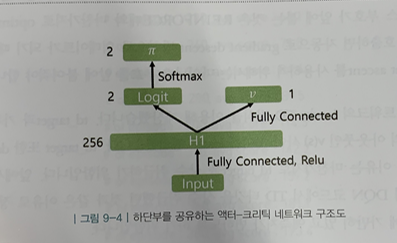

In [26]:
from IPython.display import Image
Image('./image/9-1.png')